In [16]:
import ODESolve
import numba as nb
import numpy as np
import derivatives as der
import interp
import simp_spreading as cv
import coll_varbins as cvv
import Collision_approx as ca
import os
import shutil
import RunSterileDecay as RSD
import matplotlib.pyplot as plt

from Constants import mpi_neutral

from var_param import f_TINY, f_MINI, f_SMALL, f_BUFFER, MIN_eps_BUFFER, a_MAXMULT, eps_small_MAX, len_y_MAX, small_boxsize, eps_small_box, num_small_boxes, initial_boxsize


@nb.njit()
def infl(k):
    return int(np.round(k,0))

@nb.njit()
def find_breaks(f, E5_index = 0, E2_index = 0):
    k = np.ones(3) * (len(f) - 1)
    
    if (len(np.where(f < f_TINY)[0]) > 0):
        k[0] = np.where(f < f_TINY)[0][0]
    if (len(np.where(f < f_MINI)[0]) > 0):
        k[1] = np.where(f < f_MINI)[0][0]
    if (len(np.where(f < f_SMALL)[0]) > 0):
        k[2] = np.where(f < f_SMALL)[0][0]
    
    for i in range(infl(k[0]), len(f)):
        if f[i] > f_TINY:
            k[0] = i+1
    for i in range(infl(k[1]), len(f)):
        if f[i] > f_MINI:
            k[1] = i+1
    for i in range(infl(k[2]),len(f)):
        if f[i] > f_SMALL:
            k[2] = i+1

    for j in range(3):
        for i in [E5_index, E2_index]:
            if i - MIN_eps_BUFFER < k[j] <= i:
                k[j] += 2 * MIN_eps_BUFFER
            if i <= k[j] < i + MIN_eps_BUFFER:
                k[j] += MIN_eps_BUFFER
        for jj in range(j+1,3):
            if k[jj] < k[j] + MIN_eps_BUFFER:
                k[jj] = k[j] + MIN_eps_BUFFER
        if k[j] >= len(f):
            k[j] = len(f) - 1
    return k

@nb.njit()
def make_p(a0, eps, f, p_fix, A_model, n_model):
    len_eps = len(eps)
    p = np.zeros(len_eps + 11)
    p[:len_eps] = eps
    p[-4:] = p_fix
    p[-10] = len_eps
    p[-11] = eps[-1] - eps[-2]
    
    p[-8] = A_model
    p[-9] = n_model
    
    ms = p_fix[-1]
    EB5 = ms/2
    EB2 = (ms**2 - mpi_neutral**2)/(2*ms)
    
    p[-7:-4] = find_breaks(f, E5_index = np.where(eps < EB5 * a0)[0][-1], E2_index = np.where(eps < EB2 * a0)[0][-1])
    
    return p

@nb.njit()
def find_a_MAX(a0, t, p):
    ms = p[-1]
    tau = p[-2]
    D = p[-3]
    len_eps = infl(p[-10])
    deps_last = p[-11]
    
    EB5 = ms/2
    EB2 = (ms**2 - mpi_neutral**2)/(2*ms)
    
    
    f_FULL = 2 * np.pi**2 * der.nH(t, 1/a0, p[-2], p[-3]) / ( 1/a0 * EB5**2 * deps_last )
    decay_on = True
    
    if f_FULL < f_BUFFER:
        decay_on = False
        
    a_max = a0 * a_MAXMULT
    
    if decay_on:
        a_max = min(a_max, p[len_eps - 2 * MIN_eps_BUFFER - 1] / EB2)
    
    return a_max, decay_on

@nb.njit()
def driver(a0, eps0, y0, dx0, N_steps, dN, A_model, n_model, p_fix):
    a_MAX, decay_on = find_a_MAX(a0, y0[-1], make_p(a0, eps0, y0[:-2], p_fix, A_model, n_model))
    
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    
    out_a = np.zeros(N_steps+1)
    out_y = np.zeros((N_steps+1, len(y0)))
    out_dx = np.zeros(N_steps+1)
    
    last_ind = N_steps
    
    eps_small = np.where(y0[:-2] > f_SMALL)[0][-1]
    eps_buffer = np.where(y0[:-2] > f_BUFFER)[0][-1]
    
    out_a[0] = a0
    out_y[0,:] = y0
    out_dx[0] = dx0
    
    for ns in range(N_steps):
        params = make_p(a, eps, y[:-2], p_fix, A_model, n_model)
                
        ode_out = ODESolve.ODEOneRun(a, y, dx, params, 1, dN, a_MAX)
        
        a = ode_out[0][-1]
        dx = ode_out[2][-1]
        y = np.copy(ode_out[1][-1])
        
        out_a[ns+1] = a
        out_y[ns+1][:] = y
        out_dx[ns+1] = dx
        
        if ode_out[3]:
            last_ind = ns + 1
            break
            
        eps_check = np.where(y[:-2] > f_SMALL)[0][-1]  
        if eps_check - eps_small > (eps_buffer - eps_small) / 2:
            last_ind = ns + 1
            break

            
    
    return out_a[:(last_ind+1)], out_y[:(last_ind+1),:], out_dx[:(last_ind+1)], decay_on

@nb.njit()
def forward(mH, y_v, e_array, a, decay_on):
    eps_small_new = np.where(y_v[:-2] > f_SMALL)[0][-1]
    xp = np.zeros(2)
    yp = np.zeros(2)
    kk = 0
    while (yp[1] >= yp[0]):
        if eps_small_new + kk >= len(e_array):
            break
        else:
            for i in range(2):
                yp[i] = y_v[eps_small_new + kk + i - 1]
                xp[i] = e_array[eps_small_new + kk + i - 1]
            kk += 1
            
    if eps_small_new + kk == len(e_array):
        print("f is increasing at last box?")
        return y_v, e_array
    
    eps_small_new = eps_small_new + kk
    bxsz = abs(xp[1] - xp[0])
    new_len = len(y_v)
    if y_v[eps_small_new] < f_BUFFER:
        new_len = eps_small_new
    else:
        if decay_on:
            e_up = np.where(e_array < 0.5 * mH * a)[0][-1]
            if e_up > len(e_array) - 2 * MIN_eps_BUFFER:
                e_up += MIN_eps_BUFFER * 3
            e_test = e_array[eps_small_new-1] + (new_len - (MIN_eps_BUFFER + 1) - eps_small_new) * bxsz
            while (e_test - 3*MIN_eps_BUFFER * bxsz)/a <= 0.5 * mH:
                e_up += MIN_eps_BUFFER
                e_test = e_array[eps_small_new-1] + (e_up - (MIN_eps_BUFFER + 1) - eps_small_new) * bxsz
            
            e_temp = max(eps_small_new, e_up)
        else:
            e_temp = eps_small_new
            
        if e_temp > len(y_v) - 5:
            new_len = e_temp
            
            eps_small_new = np.where(y_v[:-2] > np.sqrt(f_SMALL*f_BUFFER))[0][-1]
            yp[0] = y_v[eps_small_new-1]
            yp[1] = y_v[eps_small_new]
            xp[0] = e_array[eps_small_new-1]
            xp[1] = e_array[eps_small_new]
            
            while yp[1] > yp[0]:
                eps_small_new += 2
                yp[0] = y_v[eps_small_new-1]
                yp[1] = y_v[eps_small_new]
                xp[0] = e_array[eps_small_new-1]
                xp[1] = e_array[eps_small_new]
                
        else:
            if y_v[e_temp] < f_BUFFER:
                new_len = e_temp
                eps_small_new = e_temp
            else:
                new_len = e_temp
                
                yp[0] = y_v[e_temp]
                yp[1] = y_v[e_temp+1]
                xp[0] = e_array[e_temp]
                xp[1] = e_array[e_temp+1]
                e_extrap = e_temp

                while e_temp < len(y_v) - 5:
                    if y_v[e_temp] < f_BUFFER:
                        break
                    if y_v[e_temp+1] < y_v[e_temp] and yp[1]/yp[0] > y_v[e_temp+1]/y_v[e_temp]:
                        yp[0] = y_v[e_temp]
                        yp[1] = y_v[e_temp+1]
                        xp[0] = e_array[e_temp]
                        xp[1] = e_array[e_temp+1]
                        e_extrap = e_temp
                    e_temp += 2
                
                for i in range(20*eps_small_new):
                    if interp.log_linear_extrap(xp[0] + i * bxsz, xp, yp) > f_BUFFER:
                        new_len = i + e_extrap
                    else:
                        break
                    
                eps_small_new = e_extrap
    y = np.zeros(new_len+2)
    y[-1] = y_v[-1]
    y[-2] = y_v[-2]
    eps_array = np.zeros(new_len)
    for i in range(eps_small_new):
        eps_array[i] = e_array[i]
        y[i] = y_v[i]
    if len(eps_array) > eps_small_new:
        for i in range(eps_small_new, len(eps_array)):
            eps_array[i] = e_array[eps_small_new-1] + (i+1 - eps_small_new) * bxsz
            y[i] = interp.log_linear_extrap(eps_array[i], xp, yp)

    return y, eps_array

def nextstep(a0, eps0, y0, dx0, N_steps, dN, p_fix, fn, nr):
    
    input_filename = fn + "/inputs-{}".format(nr)
    output_filename = fn + "/full-{}".format(nr)
    
    A_model, n_model = ca.model_An(a0, y0[-2])

    np.savez(input_filename,ms=p_fix[-1],mixangle=p_fix[-4],a0=a0,y0=y0,dx0=dx0,e_array=eps0,A_model=A_model,n_model=n_model)
    
    result = driver(a0, eps0, y0, dx0, N_steps, dN, A_model, n_model, p_fix)
    
    np.savez(output_filename,ms=p_fix[-1],mixangle=p_fix[-4],a=result[0],y=result[1],dx=result[2],eps=eps0)
    
    y_next, eps_next = forward(p_fix[-1], result[1][-1], eps0, result[0][-1], result[3])
    
    return result[0][-1], eps_next, y_next, result[2][-1]


def run_code(a0, eps0, y0, dx0, p_fix, temp_fin, folder_name):
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    for i in range(200):
        a, eps, y, dx = nextstep(a, eps, y, dx, 100, 100, p_fix, folder_name, i)
        
        eps_small = np.where(y[:-2] > f_SMALL)[0][-1]
        if eps_small > eps_small_MAX or len(y) > len_y_MAX:
            y, eps = cv.simple_spread_eps(y, eps)
            
        if y[-2] < temp_fin:
            break

def run_code_error(folder_name, inputs_file):    
    in_npz = np.load("{}/{}".format(folder_name,inputs_file))
    a = float(in_npz['a0'])
    y = in_npz['y0']
    eps = in_npz['e_array']
    dx = float(in_npz['dx0'])
    
    p_fix = make_p_fixed(float(in_npz['ms']), float(in_npz['mixangle']), 1/1.79**3)

    fn = "{}/debug".format(folder_name)    
    if not os.path.exists(fn):
        os.makedirs(fn)
    else:
        print("Folder {} already exists.  Overwriting any data".format(fn))
        
    shutil.copy("{}/{}".format(folder_name,inputs_file), "{}/debug/original-{}".format(folder_name, inputs_file))


    for i in range(200):
        a, eps, y, dx = nextstep(a, eps, y, dx, 10, 5, p_fix, fn, i)

def run_code_w_error(a0, eps0, y0, dx0, p_fix, temp_fin, folder_name):
    a = a0
    eps = np.copy(eps0)
    y = np.copy(y0)
    dx = dx0
    for i in range(200):
        try:
            a, eps, y, dx = nextstep(a, eps, y, dx, 100, 100, p_fix, folder_name, i)
            
            eps_small = np.where(y[:-2] > f_SMALL)[0][-1]
            if eps_small > eps_small_MAX or len(y) > len_y_MAX:
                y, eps = cv.simple_spread_eps(y, eps)
            
            if y[-2] < temp_fin:
                break
        except:
            try:
                run_code_error(folder_name, "inputs-{}.npz".format(i))
                print("Error occurred in Run {}.  Somehow error was not repeated".format(i))
            except:
                print("Error occurred in Run {}.  Debugging runs completed.".format(i))                
            return -1
    return i

@nb.njit()
def make_p_fixed(ms,mixangle,D):
    p_out = np.zeros(4,dtype=np.float64)
    p_out[-1] = ms
    p_out[-2] = der.tH(ms,mixangle)
    p_out[-3] = D
    p_out[-4] = mixangle
    return p_out

@nb.njit()
def det_new_ics(T_i):
    a = 1/T_i
    eps_small = - int(np.log(f_SMALL)/initial_boxsize)
    eps_buffer = max(eps_small + MIN_eps_BUFFER, - int(np.log(f_BUFFER)/initial_boxsize))

    initial_size = int((eps_buffer * initial_boxsize - eps_small_box)/initial_boxsize) + num_small_boxes
    y = np.zeros(initial_size + 2)
    eps_arr = np.zeros(initial_size)
    for i in range(num_small_boxes):
        eps_arr[i] = i * small_boxsize
        y[i] = 1 / (np.exp(eps_arr[i])+1)
    for i in range(num_small_boxes, len(eps_arr)):
        eps_arr[i] = eps_arr[num_small_boxes-1] + (i+1-num_small_boxes) * initial_boxsize
        y[i] = 1 / (np.exp(eps_arr[i])+1)
    y[-2] = T_i

    return a, y, eps_arr

def N_eff(a_f,T_f,f_final,e_a): #this code assumes that y_final does not have both neutrino & antineutrino information
    TCM = 1/a_f 
    e_dens = (TCM**4/(2*np.pi**2))*der.trapezoid(f_final*e_a**3,e_a)
    neff = e_dens/((7/4)*(4/11)**(4/3)*(np.pi**2/30)*(T_f)**4)
    return 6*neff #to account for all 3 flavors of neutrinos and all 3 flavors of antineutrinos



def run(ms, mixangle, T0 = 15, D = 1/1.79**3, Tfin = 0.001):
    p_fix = make_p_fixed(ms, mixangle, D)

    a0, y0, eps0 = det_new_ics(T0)
    dx0 = a0/1000

    print("Mass = {} MeV; Lifetime = {:.3} s".format(ms,p_fix[-2]*6.58e-22))
    
    fn = "{}-{:.4}".format(ms,mixangle)

    if not os.path.exists(fn):
        os.makedirs(fn)
    else:
        print("Folder {} already exists.  Overwriting any data".format(fn))

    i_final = run_code_w_error(a0, eps0, y0, dx0, p_fix, Tfin, fn)
    
    if i_final != -1:
        read_npz = np.load("{}/full-{}.npz".format(fn,i_final))
        af = read_npz['a'][-1]
        Tf = read_npz['y'][-1,-2]
        f_f = read_npz['y'][-1,:-2]
        e_f = read_npz['eps']
        print("N_eff = {:.5}".format(N_eff(af, Tf, f_f, e_f)))
    
    
#    print("N_eff = {}".format(run_Neff(fn+"full")))



In [12]:
aaa=np.load("mass-300-life-0.912.npz",allow_pickle=True)

In [13]:
aaa.files

['mass',
 'mixing',
 'lifetime',
 'neff',
 'scalefactors',
 'time',
 'temp',
 'Tcm',
 'e',
 'fe',
 'NumbDensityDist',
 'decayrate',
 'collisionrate',
 'n_p_rate',
 'p_n_rate']

In [28]:
eps = aaa['e'][200]
y = np.zeros(len(eps)+2)
y[:len(eps)]=aaa['fe'][200]
y[-1]=aaa['temp'][200]
y[-2]=aaa['time'][200]

yy,x = cvv.simple_spread_eps(y,eps)
yyy,xx = cv.simple_spread_eps(y,eps)

<Figure size 432x288 with 0 Axes>

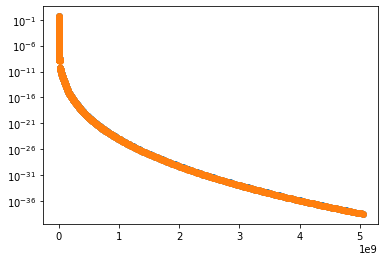

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure()
plt.semilogy(x**3,yy[:-2], '-o')
plt.semilogy(xx**3,yyy[:-2], '-o')
#plt.xlim(10,20)
#plt.ylim(10**-16,10**-6)
plt.figure()

In [46]:
yyy[:-2]/yy[:-2]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.85895654, 0.88462097,
       0.90009106, 0.91134998, 0.91765778, 0.92385806, 0.9276826 ,
       0.93185825, 0.93538643, 0.93841743, 0.94107892, 0.94346919,
       0.94559477, 0.94749198, 0.94919145, 0.95071839, 0.95208775,
       0.95331321, 0.95441056, 0.95526673, 0.95617127, 0.95678618,
       0.95725523, 0.95756366, 0.95732812, 0.95758536, 0.95721994,
       0.95655973, 0.96063609, 0.96090421, 0.9606683 , 0.96023493,
       0.9595717 , 0.95860799, 0.95873545, 0.96606206, 0.96655755,
       0.96705878, 0.96757333, 0.96810792, 0.96866895, 0.96938

In [48]:
def trapezoid(y_array,x_array):
    total = np.sum((x_array[1:]-x_array[:-1])*(y_array[1:]+y_array[:-1])/2)
    return total
meaned = trapezoid(yyy[:-2],xx)
maxed = trapezoid(yy[:-2],x)

In [50]:
print(meaned,maxed,meaned/maxed)

0.6958392962397983 0.6959038790467796 0.999907195793951


In [51]:
original = trapezoid(aaa['fe'][200],aaa['e'][200])

In [54]:
print(original,meaned/original)

0.6957882308749997 1.0000733921077314


In [55]:
print(maxed/original)

1.0001662117389287


In [67]:
x=np.linspace(0,343,344)
ratio_mean=np.zeros(len(x))
ratio_max=np.zeros(len(x))
for i in range(len(aaa['e'])):
    eps = aaa['e'][i]
    y = np.zeros(len(eps)+2)
    y[:len(eps)]=aaa['fe'][i]
    y[-1]=aaa['temp'][i]
    y[-2]=aaa['time'][i]
    y_new,e = cv.simple_spread_eps(y,eps)
    y_maxed,e = cvv.simple_spread_eps(y,eps)
    y_trap = trapezoid(y_new[:-2],e)
    y_trap_max = trapezoid(y_maxed[:-2],e)
    ratio_mean[i]=y_trap/original
    ratio_max[i]=y_trap_max/original

<Figure size 432x288 with 0 Axes>

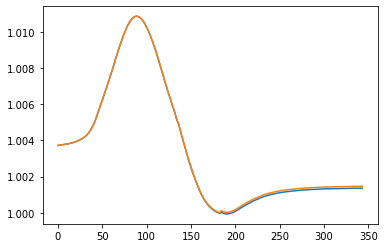

<Figure size 432x288 with 0 Axes>

In [75]:
plt.figure()
plt.plot(x,ratio_mean)
plt.plot(x,ratio_max)
#plt.xlim(50,150)
#plt.ylim(1,1.011)
plt.figure()

In [104]:

def epsilon_tester(l):
    eps = aaa['e'][l]
    y = np.zeros(len(eps)+2)
    y[:len(eps)]=aaa['fe'][l]
    y[-1]=aaa['temp'][l]
    y[-2]=aaa['time'][l]
    y_new,e_new = cv.simple_spread_eps(y,eps)
    y_maxed,e_max = cvv.simple_spread_eps(y,eps)
    
    original = trapezoid(aaa['fe'][l],aaa['e'][l])
    y_trap = trapezoid(y_new[:-2],e_new)
    y_trap_max = trapezoid(y_maxed[:-2],e_max)
    #can print the above integrals if needed...
    
    plt.figure()
    plt.loglog(e_new,y_new[:-2]*e_new**3)
    plt.loglog(e_max,y_maxed[:-2]*e_max**3)
    plt.loglog(eps,aaa['fe'][l]*eps**3)
    #plt.xlim(10,20)
    #plt.ylim(10**-16,10**-6)
    plt.figure()

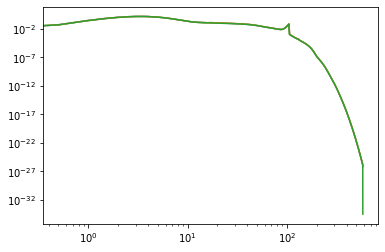

<Figure size 432x288 with 0 Axes>

In [105]:
epsilon_tester(135)

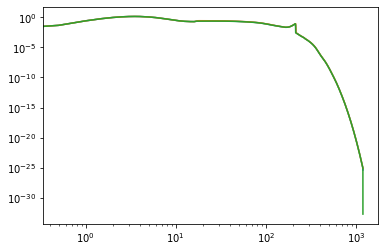

<Figure size 432x288 with 0 Axes>

In [92]:
epsilon_tester(183)

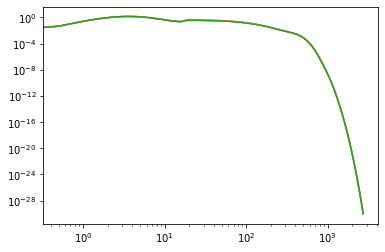

<Figure size 432x288 with 0 Axes>

In [93]:
epsilon_tester(334)

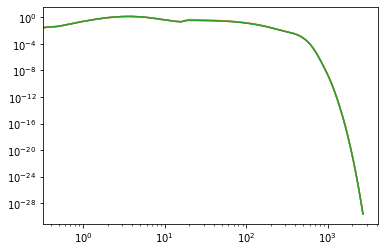

<Figure size 432x288 with 0 Axes>

In [95]:
epsilon_tester(335)

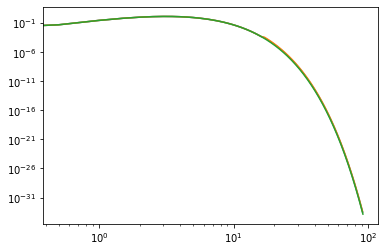

<Figure size 432x288 with 0 Axes>

In [106]:
epsilon_tester(16)